# Working with PRISM data

Travis Zalesky (The University of Arizona)

## 1 Abstract

Parameter-elevation Regressions on Independent Slopes Model (PRISM) data is available from Oregon State University for a variety of common climate variables such as min/max temperature, precipitation, dew point etc. These datasets are extremely useful in a variety of research applications, and they can be conveniently accessed through the [PRISM website](https://prism.oregonstate.edu/), or they can be accessed programmatically through the data api using the R package [prism](https://cran.r-project.org/web/packages/prism/index.html).

While the prism R package is great, the goal of this tutorial, and associated script, is to extend the prism package to solve a common problem. PRISM data is delivered as a raster for the contiguous US (at 4Km or 800m resolution), when often only a much smaller extent is needed to answer the research question at hand. Depending on the project, storing a large number of rasters for the whole US may be unnecessary and could massively increase data storage costs. Originally developed for a research project covering the Phoenix metro area this script is designed to work with a shapefile defining the area of interest, and includes a variety of functions which will iteratively (1) download the requested data file from PRISM, (2) clip the data to the study area, and (3) save the output clipped raster, preserving all relevant metadata and file structure. The original (US extent) data files are then, optionally, deleted to save storage space.

### 1.1 Objectives

1.  Bulk download data from prism.oregonstate.edu.
2.  Crop data to a given study area using a shapefile.
3.  Save cropped data sets, preserve file metadata and .bil format.
4.  Delete raw data (optional).

## 2 Downloading PRISM data

### 2.1 WARNING!

**Repeated downloading of files from the PRISM api may result in sanctions, including blocking your IP address. Please be respectful of these resources.**

### 2.2 Setup

As with any R \[[1](#ref-base_R)\] script, we must first load the required packages. Initially we will utilize 2 packages, prism and lubridate. The prism \[[2](#ref-prism)\] package is the primary R package for programmatically interacting with the PRISM api. Lubridate \[[3](#ref-lubridate)\] is a package for working with dates, and will be used for its `years()` function.

```` markdown
```{r}
 Setup ----
# Packages
# Check if packages are installed, if not download
# PRISM api package 'prism'
if(!require('prism')) {  
  # if package is not available, require() returns FALSE
  install.packages('prism')  # install the package
  library(prism)  # Attach the package
}
# Working with dates 'lubridate', required for year() function
if(!require('lubridate')) {  
  # if package is not available, require() returns FALSE
  install.packages('lubridate')  # install the package
  library(lubridate)  # Attach the package
}
```
````

Next we set the working directory (wd). This is the absolute file path in your machine in which all the files exist, and where data will be downloaded. Relative file paths will begin at the working directory.

Here I have used the R function `getwd()` to obtain the default working directory from your R session. This is primarily used to make sharing this script easier and more convenient, but it is highly recommended that you change the var `dir.string` to an absolute file path representing your preferred file location, as this will be used extensively while downloading and managing your PRISM data.

```` markdown
```{r}
# Set Working Directory (wd)
dir.string <- getwd()  # Update with directory string as needed!
setwd(dir.string)
getwd()  # Check wd
```
````

Next we will create a new folder in our wd called “Data”, and set it as the default data download directory for the PRISM api using the `prism_set_dl_dir()` function.

```` markdown
```{r}
# Create Data folder in wd
dir.create("Data")  # Ignore warning if dir already exists

# Assign prism download directory
# Use the paste() function to concatenate the full file path
# Use full directory path for more robust code (less error prone)
prism_set_dl_dir(paste(dir.string, "Data", sep = "/"))
```
````

### 2.3 Defining variables of interest

Now that we have set up our directory, we next must define the date range and variables of interest. Here I have defined a date range and set of variables for this tutorial, but in the future, this will be the section of code which you will primarily be responsible for updating to suit the needs of your project.

#### 2.3.1 Setting a date range

At minimum, a date range is required for data to download. Depending on the data set that you are interested in, some PRISM records extend back as far as 1895, and new data is typically made available in near real time. Here we will look for data from the beginning of 2020 through 2022.

```` markdown
```{r}
# Define date range
min.Date <- "2020-01-01"
max.Date <- "2022-12-31"
# For the most up to date data available, use max.Date <- lubridate::today()
```
````

Additionally, in some instances you may only be interested in a certain months of the year. You may optionally set a range of months here. If no months are defined, the default behavior will be to download all months of the year (if applicable). In this example we will only look at data from April to July (4 to 7).

```` markdown
```{r}
# Optional: list of months to download for the get_prism_monthlies() function
months <- c(4:7)  # Numeric list, not strings!
```
````

#### 2.3.2 Setting temporal resolution

PRISM data is available at four temporal scales, daily, monthly, annual, and 30-year normals. While you are free to experiment with the prism functions `get_prism_dailys()`, `get_prism_monthlys()`, `get_prism_annual()`, and `get_prism_normals()` the scripts included with this tutorial have already set up the functions so that you can quickly and efficiently get the data you need with a minimum number of changes.

Some things to consider at this point, firstly, in some instances you may want a dis-continuous data set, such as daily observations for the month of July from 1999 to 2020. Unfortunately, none of these scripts are currently able to accept a dis-continuous date range. Your choices are to either download the full continuous dataset and subset the data after it has been downloaded, break the dataset into smaller blocks of continuous dates and run multiple times, or write your own custom script for handling date breaks. Also, the way that I have written the `get_prism_monthlys()` and `get_prism_normals()` functions may sometimes result in unexpected behavior, depending on the `min.date` and `max.date` provided. In short, the function extracts the year from the date variables, and the rest of the date bounds are disregarded. Therefore, you may get more data than you expect, but the error will always be inclusive (as opposed to not downloading requested data).

```` markdown
```{r}
# Define temporal resolution
# tRes must be one of "dailys", "monthlys", "annual", "normals"
tRes <- "monthlys"
```
````

#### 2.3.3 Setting the climatic variables

There are 11 climactic variables available through PRISM, of which seven are available through the api. These are precipitation (ppt), mean temperature (tmean), minimum temperature (tmin), maximum temperature (tmax), mean dew point temperature (tdmean), minimum vapor pressure deficit (vpdmin), and maximum vapor pressure deficit (vpdmax). Any combination of these variables may be assigned to the `prismVars` variable, and all the requested climactic data will be downloaded.

```` markdown
```{r}
# Define data variables
# Must be one (or several) of "ppt", "tmean", "tmin", "tmax", "tdmean", "vpdmin", "vpdmax"
# Use c("var1", "var2", etc...) for multiple variables
prismVars <- c("ppt", "tdmean")
# Missing variables not available through the PRISM api = 
#   "Soltotal", "Solslope", "Solclear", "Soltrans"
```
````

### 2.4 Downloading the data

Now that we have defined the data to download, we can execute the prism functions to connect to the api and commence data downloading. But first we will run a couple of simple checks.

To make sure that the `tRes` variable is set correctly we will check it against a list. If an issue is detected it will return a custom error message which will warn the user to double check their work.

```` markdown
```{r}
# Check if temporal resolution (tRes) is set correctly.
# If tRes not in list
if (tRes != "dailys" & tRes != "monthlys" & tRes != "annual" & tRes != "normals") {
  # Print a custom error message
  stop('tRes must be one of "dailys", "monthlys", "annual", or "normals". Please ensure your variable is set correctly.')
}
```
````

Next, to avoid potentially costly user errors an if statement is called so that only the data of interest is downloaded. This way all of the prism `get_prism_...()` functions can be prebuilt and live inside our script, enabling us to work quickly, but (hopefully) preventing us from running the wrong function and ending up with way too much data. Here I am only showing the `get_prism_monthlies()` function which we are interested in. See the full prism.R script accompanying this tutorial to see how all the functions are defined.

Depending on the amount of data requested this function may take from seconds to hours. It includes several convenient progress statements, and is nested inside a timing function. This small example should take about 35 seconds to complete.

```` markdown
```{r}
# If tRes is "monthlys"
# Monthlies ----
if (tRes == "monthlys") {
  system.time({ #Timing function.
    # Check if var "months" is defined
    if (exists("months")) {
      # If exists() = TRUE
      months <- months  # Use months as defined
    } else {
      months <- c(1:12)  # else, default to all months of the year.
    }
    # For each prism climactic variable in list of prismVars
    for (prismVar in prismVars) {
      print(prismVar)  # Print the current variable
      # Use the prism::get_prism_monthlys() function to connect to the PRISM api
      get_prism_monthlys(type = prismVar, # dataset to be downloaded
                         # Date range
                         # Use lubridate::years() function to extract the year from the min/max date vars
                         # Generate a regular sequence from min year to max year
                         years = year(seq(as.Date(min.Date), as.Date(max.Date), by="years")),
                         mon = months,  # Months to download
                         keepZip = F)  #delete zip folders
      
    } # end for prismVar in prismVars
  }) # end system.time
}
```
````

### 2.5 Checking the raw data

At this point all your data should have downloaded into the “Data” folder. You can check on your files using the file explorer (or finder on Mac). We will use a custom function to check our files programmatically and return the total size of files in our directory, this will also allow us to quantify the storage savings after we have cropped our files in <a href="#sec-cropData" class="quarto-xref">Section 3.4</a>.

```` markdown
```{r}
# Optional: Check size of downloaded data
dir_size <- function(path, recursive = TRUE) {
  stopifnot(is.character(path))
  files <- list.files(path, full.names = T, recursive = recursive)
  vect_size <- sapply(files, function(x) file.size(x))
  size_files <- sum(vect_size)
  size_files  # return file size in bytes
}
rawDataSize <- dir_size("Data")/10**6  # bytes to MB
# Print statement
cat(paste("Data folder size on disk =", rawDataSize, "MB", sep = " "))
```
````

Approximate size of files on disk = 105 MB.

## 3 Cropping PRISM data to study area

So far, we have been working primarily with the prism package, and have succeeded in connecting to the PRISM api and efficiently downloading data in bulk. However, this could arguably have been achieved just as efficiently by simply calling the required function from the prism package. Here we will extend the useful application of the prism package by incorporating functions from the terra package \[[4](#ref-terra)\] to crop the data to a study area, thereby saving ourselves from the enormous data storage costs of maintaining nationwide datasets, when we are only interested in a small region.

In our example we will look at Maricopa County, AZ.

### 3.1 Setup

While contained within the same script for convenience, the code presented in this section is independent from the code presented in <a href="#sec-prism" class="quarto-xref">Section 2</a>. You may continue in your R session or may restart your R session as desired.

Let’s begin by loading the terra package.

```` markdown
```{r}
# Packages
# "terra" package for working with geospatial datasets
if(!require('terra')) {  # if package is not available, require() returns FALSE
  install.packages('terra')  # install the package
  library(terra)  # Attach the package
}
```
````

### 3.2 Exploring the data

While we could jump straight into the automated data processing, it is generally a good idea to take a moment to explore your data prior to bulk processing. This will also afford us the opportunity to briefly explore some of the functions of terra \[[4](#ref-terra)\], a massively useful package for geospatial data analysis in R!

First, let’s just load in a representative data folder, and a raster file. Here I will be using a regular expression (regex) for pattern matching. Regex is largely beyond the scope of this tutorial, but it is a wildly useful programmatic tool for advanced users. I will do my best to include plain language explanations for all my regex patterns, but for those who are interested in learning more I highly recommend reading this [vignette](https://cran.r-project.org/web/packages/stringr/vignettes/regular-expressions.html) on cran.

```` markdown
```{r}
# Locate Raster files, "bil" extension.
folder1 <- list.files("Data")[1] # Select first data folder in download directory
file1 <- list.files(paste("Data", folder1, sep = "/"), 
                    # pattern = regex, literal "bil.bil" at end of string.
                    pattern = "bil.bil$",
                    # Full file path 
                    full.names = T)
# There should only be one .bil file per data folder
# Get file name from file path
# Use length() function to return the last item in the list (i.e. index = length(list))
name <- strsplit(file1, split = "/")[[1]][length(strsplit(file1, split = "/")[[1]])]
```
````

#### 3.2.1 Loading raster data

Loading raster data in R is as simple as calling the terra `rast()` function, with the file path to the data. After loading the raster (i.e. terra “spatRast” object) we can map it using `terra::plot()`. Note that when terra was loaded the terra `plot()` function automatically masked the base R `plot()` function and can be called simply `plot()`.

```` markdown
```{r}
# Load raster data, plot
rast1 <- rast(file1)  # terra spatRaster object
plot(rast1, main = name)  # Check if data loaded correctly
```
````

<figure>
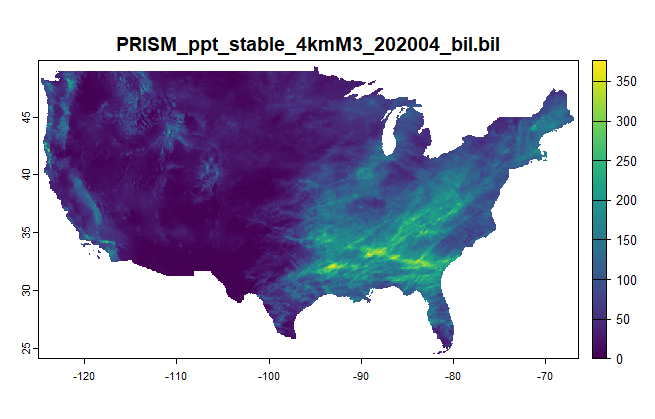
<figcaption aria-hidden="true">PRISM precipitation data for April, 2020.</figcaption>
</figure>

#### 3.2.2 Loading vector data

Similar to loading raster data, vector data can be loaded very simply using the terra `vect()` function. The resulting vector data is a “spatVect” object. When loading shapefiles, which consist of several related files in a standard structure, only the .shp file needs to be called, however any missing files not present in the given shapefile directory may cause unexpected errors.

```` markdown
```{r}
# Load shapefile for clipping data extent
# Example = Maricopa County, AZ
shp_path <- list.files("Shapefile",  # Relative file path
                      # pattern = regex, ".shp" at end of string.
                      pattern = ".shp$",  
                      # Full file path
                      full.names = T)
shp <- vect(shp_path)  # terra spatVector object
plot(shp)  # Check if data loaded correctly
```
````

<figure>
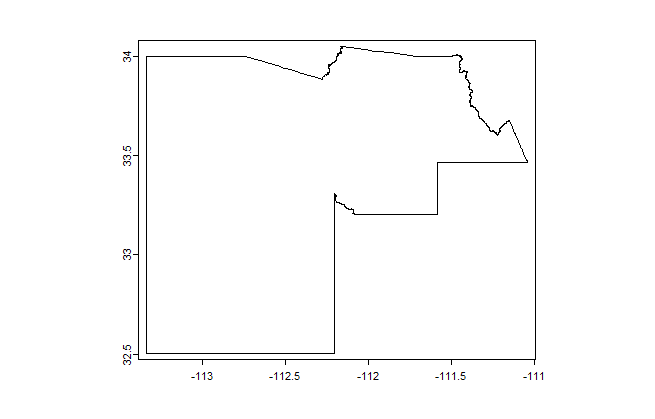
<figcaption aria-hidden="true">Maricopa County, AZ shapefile data</figcaption>
</figure>

#### 3.2.3 Data projections

**IMPORTANT!** Geospatial data projections are a complex and highly technical field, related to the 2-dimensional representation of 3-dimensional objects. While I will refrain from a long tangent on map projections, suffice to say that projections are critical for mapping as well as ensuring accurate measurements. Unlike other commercial GIS software, terra will not perform “on the fly” projections, so all geospatial data must use a similar projection to be mapped appropriately.

Here we will use an Arizona State Plane, Central (ft, EPSG:2223), which is appropriate for Maricopa County, AZ. For future projects discuss appropriate data projections with your project leader or GIS manager. See https://epsg.io/ to query EPSG codes for your desired projection.

```` markdown
```{r}
# Project Data
# IMPORTANT!
# Data projections control the planar (2d) shape of your map, projected from a spherical
#   (3d) space. Projections are very important for distance and area geospatial calculations
#   and will vary based on project and study area. Additionally, projections between data
#   layers must match so that they will correctly align when plotting. Terra will not 
#   perform "on the fly" projections.
# You can check your data layer projections using the terra::crs() function.
crs(rast1)  # PRISM raster(s) projection
crs(shp)  # Projection of your shapefile
# You can ignore most of the projection information here, but notice that the projections
#   do not match.
setequal(crs(rast), crs(shp))  # check if objects are equal
# For this tutorial, I will use AZ State Planes, Central projection, which is appropriate
#   for Maricopa County, AZ (EPSG:2223). Consult your PI or GIS technician for help selecting
#   the appropriate projection for your research.
projection = "EPSG:2223"
# For additional help with projections see:
#   https://epsg.io/

# Reproject data
# Reproject shp using EPSG code, overwrite shp
shp <- project(shp, projection)  # AZ State Plane, Central (ft)
# Reproject raster 1 to match with shp, overwrite rast1
rast1 <- project(rast1, crs(shp))
# Check projections
crs(shp)
crs(rast1)
# setequal(shp, rast1)  # I am not sure why this is returning F, but the projections are matching...
```
````

Now that we have set our data projection we can map our data layers together on a single map. First, we will map the full PRISM dataset covering the whole contiguous US, adding Maricopa county on top of our base layer.

```` markdown
```{r}
# Check projections and layer alignment
plot(rast1, main = name)  # USA will look skewed in "Arizona Central" projection
plot(shp, add = T)  # Shape will appear small on USA map, position should be correct
# If the position of your shapefile is incorrect, or if the shapefile does not appear on
#   the map, please double check your projection and try again.
# Depending on the background color and size of your study area your shapefile may be 
#   difficult to see at this stage.
```
````

<figure>
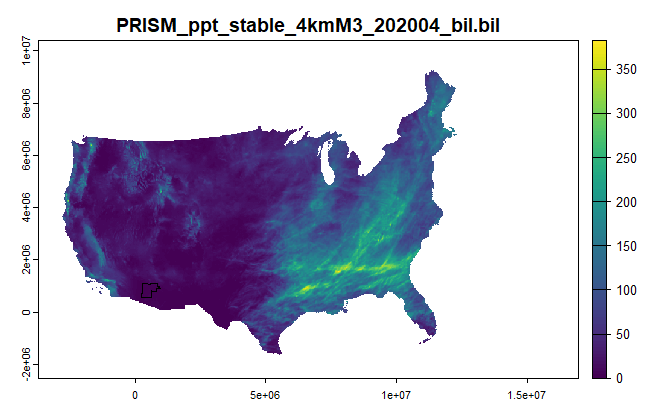
<figcaption aria-hidden="true">PRISM precipitation data, reprojected to AZ State Plane, Central (ft) EPSG:2223.</figcaption>
</figure>

Notice how strange the US looks in this projection? This is because our projection is optimized for central AZ. It is highly accurate in that area, and the further away from that region the data is, the more skewed the data becomes.

Now let’s map the data using only the extent of our shapefile, but without cropping the data layer. This is equivalent of setting the x and y scales in a typical scatterplot, without modifying the underlying data.

```` markdown
```{r}
# Define study area extent, plot
e <- ext(shp)  # extent of your shapefile
# Plot PRISM raster with limited extent
plot(rast1, ext = e, main = name)
plot(shp, add = T)
# Your shapefile should be visible as a thin outline.
```
````

<figure>
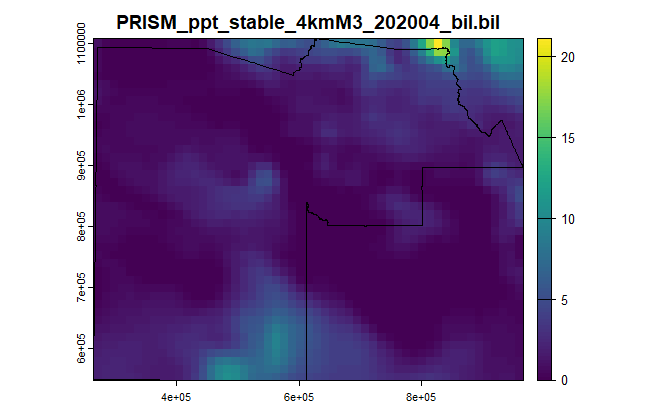
<figcaption aria-hidden="true">PRISM precipitation data, zoomed to Maricopa County, AZ.</figcaption>
</figure>

#### 3.2.4 Crop the data

Now that we have set our projection, and we have an extent that we are happy with we can crop our data layer.

```` markdown
```{r}
# Crop raster, plot
rast_crop <- crop(rast1, 1.05 * e)  # Add 5% margin to extent to avoid clipping vertices
plot(rast_crop, main = name)
plot(shp, add = T)
```
````

<figure>
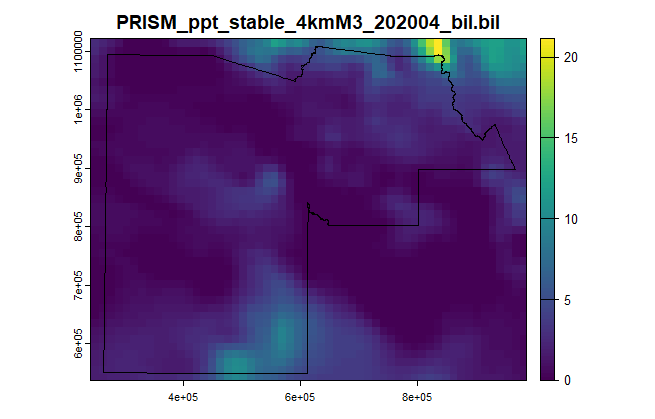
<figcaption aria-hidden="true">PRISM precipitation data, cropped to Maricopa County, AZ, with a 5% buffer to ensure that no data is clipped within the study area.</figcaption>
</figure>

#### 3.2.5 Save the output

Create a new directory for outputs and use the `writeRaster()` function to save the output.

```` markdown
```{r}
# Create directory for modified outputs
dir.create("Output", recursive = T)  # Ignore warning if dir already exists
writeRaster(rast_crop, filename = "Output/test_case.tif",
            overwrite = T)
```
````

You should now see a new “Output” folder in your wd, with a new “test_case.tif” file in it. In the next section we will automate the above processing, and we will also make a few tweaks to make sure we maintain the correct PRISM file structure, as well as all the associated metadata.

### 3.3 Automated data processing

In this section we will use some complex logic to bulk process all the data files in our “Data” folder. The raster files will be reprojected and cropped to our area of interest, and the outputs will be saved in the “Output” folder, while preserving all the PRISM data file naming conventions and file tree. All metadata will be copied to the new directory, and (optionally) the raw data will be erased.

While it is recommended that the PRISM raw data files are deleted, the data files may not be recoverable through the recycling bin. Therefore, **please be sure that you do not need to retain the raw data before proceeding, as repeated downloading of data from the PRISM api may not be possible**.

```` markdown
```{r}
# Optional vars
retainRaw <- F  # Keep raw data (full USA extent)?
```
````

```` markdown
```{r}
# Crop all Datasets ----
# Now that we have explored our data and tested our algorithm, we can automate the cropping
#   of all the remaining files.
# Setup
# list directories
dirs <- list.dirs("Data", recursive = F)
dirs

system.time({  # Timing function
  # Load, crop, save, looping function
  # For directory in list of directories
  for(dir in dirs) {
    i <- which(dirs == dir) # Get index number in dirs using pattern matching
    # Progress Statement
    print(paste("Processing file #", i, " of ", length(dirs), ".", sep = ""))
    
    # Explore dir
    files <- list.files(path = dir)  # Get dir contents
    # Drop extension from file, for output dir
    name <- strsplit(files[1], split = "\\.")[[1]][1]  # Split sting on literal "."
    # Create output directory
    dir.create(paste("Output/", name, sep = "/"), recursive = T)
   
    # For each file in list of files
    for (file in files) {
      # If file is .bil (raster data)
      if (grepl("bil.bil$", file) == T) {
        # Process raster data
        r <- rast(paste(dir, file, sep = "/"))  # load raster data
        r_proj <- project(r, projection)  # project
        r_crop <- crop(r_proj, ext(1.05 * ext(shp)))  # crop

        # Write cropped raster data
        # Preserve file structure and naming conventions from PRISM
        writeRaster(r_crop, 
          filename = paste("Output/", name, "/", name, ".bil", sep = ""), 
          filetype = "EHdr",  # Esri .bil format
          overwrite = T)  # Enable overwriting
      } else {  # Metadata files
        metadataFile = list.files(dir, pattern = file, full.names = T)
        # Copy metadata into output dir)
        file.copy(metadataFile,
          paste("Output/", name, sep = ""))
      }
    }  # end for file in files

    if (retainRaw == F) {
      # Delete raw data
      unlink(dir, recursive = T)
    }
  }  # end for dir in dirs
})  # end sys.time
```
````

Processing for this small example takes approximately 13 seconds.

### 3.4 Checking the cropped data

As with the raw data above, we will check the contents of our cropped data in the “Output” directory and look at how much space we have saved by cropping our data. If you restarted your R session at the beginning of <a href="#sec-terra" class="quarto-xref">Section 3</a> then you may need to rerun the `dir_size()` function in <a href="#sec-rawData" class="quarto-xref">Section 2.5</a>.

```` markdown
```{r}
# Optional: Check size of Output files
croppedDataSize <- dir_size("Output")/10**6
cat(paste("Output folder size on disk =", croppedDataSize , "MB", sep = " "))
storageSaved <- rawDataSize - croppedDataSize
cat(paste("Space saved on disk by cropping files =", storageSaved, "MB", sep = " "))
```
````

In this example we reduced our file storage from over 100 MB to less than 21 MB, a savings of nearly 80%!

## 4 Conclusions

In this simple example I have shown you how to efficiently download bulk climactic data from the PRISM api using the prism R package. I also briefly introduced the terra package and showed you how to explore and map geospatial data. Then we used a simple code block to automate the bulk processing of raw data for our area of interest, saving ~80% of file storage requirements.

Hopefully by now you feel confident in being able to apply these methods to your own study area. By updating the shapefile and modifying a few key variables you can efficiently acquire climactic data for a broad range of applications anywhere in the contiguous US. Using the R script accompanying this tutorial you can wow your supervisors and be the envy of your peers with how simply and efficiently you are able to access the data you need.

## 5 Get the code

Access the full R script used in this tutorial [here](https://github.com/travisz09/PRISM/tree/main/R-Script).

<span class="csl-left-margin">1. </span><span class="csl-right-inline">R Core Team (2024) [R: A language and environment for statistical computing](https://www.R-project.org/). R Foundation for Statistical Computing, Vienna, Austria</span>

<span class="csl-left-margin">2. </span><span class="csl-right-inline">Hart EM, Bell K (2015) [Prism: Download data from the oregon prism project](https://doi.org/10.5281/zenodo.33663)</span>

<span class="csl-left-margin">3. </span><span class="csl-right-inline">Grolemund G, Wickham H (2011) [Dates and times made easy with <span class="nocase">lubridate</span>](https://www.jstatsoft.org/v40/i03/). Journal of Statistical Software 40(3):1–25</span>

<span class="csl-left-margin">4. </span><span class="csl-right-inline">Hijmans RJ (2024) [Terra: Spatial data analysis](https://CRAN.R-project.org/package=terra)</span>